**Configuration d'un environnement d'execution local**

The easiest way is via Conda:

conda install -c conda-forge jupyterlab

or pip:

pip install jupyterlab

More detailed instructions can be found here.

Step2: Install Jupyter server extension for using a WebSocket to proxy HTTP traffic
The colab team authored thejupyter_http_over_ws extension. Install it by doing:

pip install jupyter_http_over_ws

Then enable it by doing:

jupyter serverextension enable --py jupyter_http_over_ws

You can read more detailed information about this extension on its GitHub repository.

Step 3: Start a local Jupyter server
We need a local Jupyter server that trusts WebSocket connections from the Colab frontend. The following command and flags accomplish this:

jupyter notebook \ 
    --NotebookApp.allow_origin='https://colab.research.google.com' \ 
    --port=8888 \ 
    --NotebookApp.port_retries=0

Architecture de MicMac
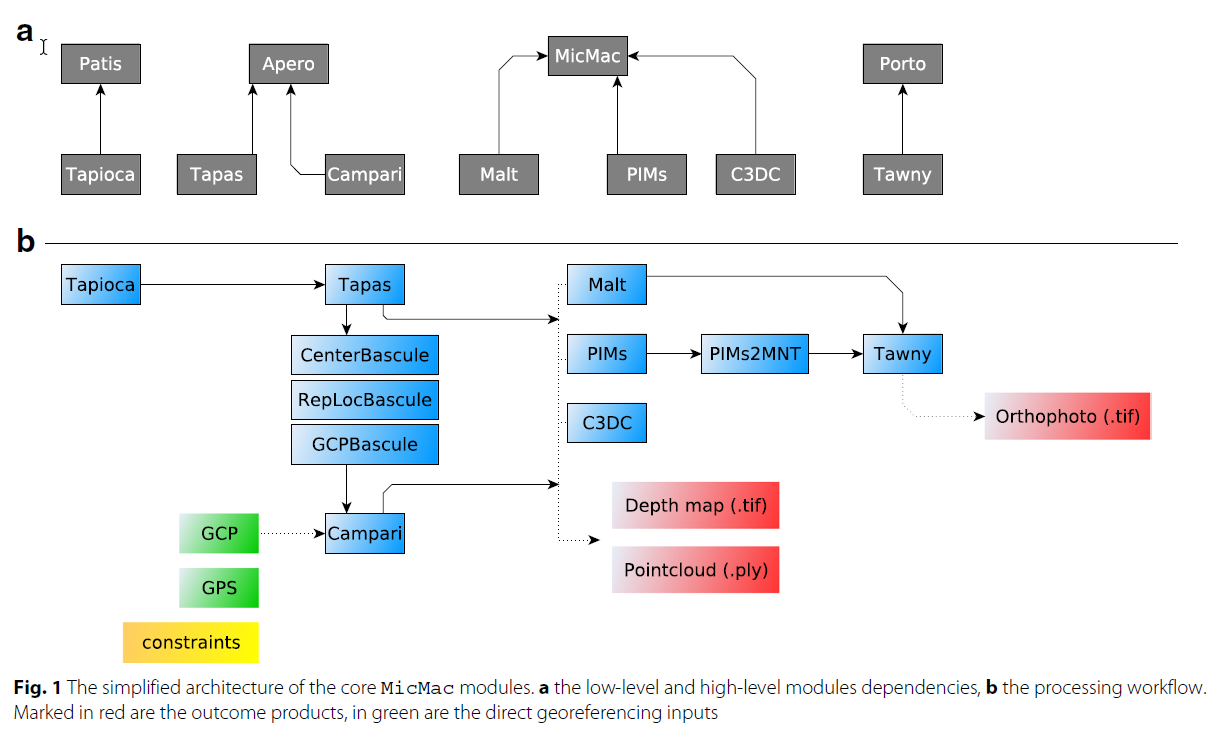

Telechargement et compilation de micmac

In [ ]:
import os
from os.path import exists, join, basename, splitext
import numpy as np 
import cv2
import matplotlib.pyplot as plt   

Dependencies_install = True
MicMac_clone = True
MicMac_cmake = True 
MicMac_build = True

YOUR_PATH = '/content/'#MyDrive/micmac/satellites/'
!cd $YOUR_PATH
!pwd


if Dependencies_install:
  !apt update
  !apt install -y cmake
  !pip install dlib
  !apt-get install imagemagick proj-bin exiv2
  !pip install wget gdown

if MicMac_clone:
  if not exists(YOUR_PATH+'micmac/'):
    git_repo_url = 'https://github.com/micmacIGN/micmac.git'
    !git clone $git_repo_url

if MicMac_cmake:
  !cd micmac
  if not exists(YOUR_PATH+'micmac/build'):
    !mkdir $YOUR_PATH"micmac/build"

  !cd $YOUR_PATH"micmac/build"
  !cmake $YOUR_PATH"micmac" -DBUILD_POISSON=OFF

  if MicMac_build:
    !make install -j28



Installation de google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Tester le fonctionnement correct de micmac


In [ ]:
import os
os.environ['PATH'] += ":/content/micmac/bin/"
!echo $PATH

# if you can see the commands printed to the screen, everything is OK
!mm3d

Telechargement des images

In [ ]:
!unzip $YOUR_PATH'/drive/MyDrive/Colab Notebooks/images.zip' -d $YOUR_PATH

# utility functions to visualise tie-points
utils_url='https://drive.google.com/uc?id=1ATO1Nz_aXApxVnm6l7x1xappGXtcjuvp'
!gdown $utils_url -O $YOUR_PATH"mm3d_utils.py"   

## 1. Extraction des tie-points avec Tapioca

Dans cette étape, nous utiliserons la commande "Tapioca" pour extraire les points d'attache (tie-points). Ces points sont utilisés pour calculer l'orientation relative des images et pour créer un modèle 3D. La qualité des points d'attache dépend de la qualité des images prises par le drone, du nombre d'images et de la couverture de la zone capturée.

Ces points d'attache sont stockés dans des fichiers temporaires qui sont créés dans le dossier "Tmp-mm-dir". Ils sont ensuite utilisés dans les étapes suivantes du traitement pour améliorer la précision de la reconstruction 3D et pour créer des images homologuées qui sont stockées dans le dossier "Homol".
  - **Resolution des images**: la résolution est indiquée comme étant égale à -1, ce qui signifie que les images sont utilisées en pleine résolution.
  - **ExpTxt=1**: Cela signifie que tous les points d'attache (tie-points) seront enregistrés sous forme de fichiers texte.
  - **Resultats**: Les points d'attache (tie-points) sont stockés dans le dossier "Homol". Par exemple, les points d'attache correspondant à l'image "Im1.tif" seront stockés dans le dossier "Homol/PastisIm1.tif/". Si l'image "Im1.tif" chevauche les images "Im2.tif" et "Im3.tif", leurs points d'attache seront stockés respectivement dans les fichiers "Homol/PastisIm1.tif/Im2.tif.dat" et "Homol/PastisIm1.tif/Im3.tif.dat". [source micmac]

In [ ]:
%cd $YOUR_PATH'images'
!mm3d Tapioca All .*JPG -1 ExpTxt=1 @ExitOnBrkp

### Visualise tie-points

Read any pair of images and visalise their tie-points.

In [ ]:
import mm3d_utils 

aIm1 = cv2.imread('TPMM_0435.tif',cv2.IMREAD_IGNORE_ORIENTATION)
aIm2 = cv2.imread('TPMM_0566.tif',cv2.IMREAD_IGNORE_ORIENTATION) 
 
TPtsVec = mm3d_utils.ImportHom("Homol/PastisTPMM_0435.tif/TPMM_0566.tif.txt") 
 
mm3d_utils.plot_images([np.asarray(aIm1),np.asarray(aIm2)]) 
mm3d_utils.plot_tiepts2(np.asarray(TPtsVec,dtype=float))

## 2. RPC-bundle adjustment

### Read the RPCs in DIMAP format

This function reads the DIMAP format RPCs and converts it to a *MicMac* format. Several parameters are specified here:

  - `(.*).tif` this is the pattern of input images (note the dot preceding the star which is the posix convention)

  - `\$1.xml` is the corresponding pattern of RPC files; I use here a regular expression that associates the image name with its corresponding RPC file name; you may also run the command independently for each image if you're not familiar with regular expressions;

  - `RPC-d0` is the directory name where the converted files will be stored; it will serve as input in the following step, i.e., the bundle adjustment;

  - `Degre=0`, the degree of the polynomial correction;

  By choosing a zero-degree polynomial we will correct the satellite's geolocalisation by modelling a 3D image shift; please refer to [Rupnik et al., 2016] for more on the method.

  - `ChSys=WGS84toUTM.xml` definition of the projection coordinate sytem; MicMac expects that the processing coordinate frame is euclidean and all three coordinates have the same unit. The RPCs are expressed in geographical coordinates which are neither euclidean, nor unique in terms of units. To overcome that, MicMac will transfer, on the fly, the RPCs to a user-defined coordinate system, in this exemple defined in the `WGS84toUTM.xml` file. The definition of the coordinate system follows the `proj4` library convention. You can retrieve the code corresponding to the coordinate frame of your interest from `https://spatialreference.org/`



<sub> Rupnik, E., Deseilligny, M.P., Delorme, A. and Klinger, Y., 2016. Refined satellite image orientation in the free open-source photogrammetric tools Apero/Micmac. ISPRS Annals of the Photogrammetry, Remote Sensing and Spatial Information Sciences, 3, p.83.<sub>

In [ ]:
!mm3d Convert2GenBundle -help @ExitOnBrkp
!mm3d Convert2GenBundle "(.*).tif" "\$1.xml" RPC-d0 ChSys=WGS84toUTM.xml Degre=0  @ExitOnBrkp

### Run the adjustment

Within the bundle adjustemnt, MicMac will estimate the parameters of $D_x$ and $D_y$ functions, that are the polynomials you have defined in `Convert2GenBundle` method. In this example our observations are the tie-points. It is also possible to include ground control points.


$\begin{equation}
\begin{split}
y = g (\phi, \lambda, h) +  {D_y (x,y)}\\
x = h (\phi, \lambda, h) +  {D_x (x,y)}
\end{split}
\end{equation}$

where $g$ and $h$ are the RPC functions, and 

$\begin{equation}
\begin{split}
D_y (x,y) = \sum_{i=0}^m \sum_{j=0}^n a_{ij} \cdot x^i y^j \\
D_x (x,y) = \sum_{i=0}^m \sum_{j=0}^n b_{ij} \cdot x^i y^j
\end{split}
\end{equation}$


The input parameters:
- `RPC-d0` is the folder with the initial geolocalisation
- `RPC-d0_adj` is the folder where the adjusted geoloc is saved
- `ExpTxt=1` indicates that tie-points are stored in text format 

In [ ]:
!mm3d Campari ".*tif" RPC-d0 RPC-d0-adj ExpTxt=1 @ExitOnBrkp

### Interpreting the results

One way to asses the quality of the adjustment is to look at the tie-points residual (for more sophisticated quality estimates see `MMTestOrient` in MicMac documentation). 

The bundle adjustment is carried out in several iterations. Let's look at image `TPMM_0435.tif` in the last iteration:

> `RES:[TPMM_0435.tif][g] ER2 0.24636 Nn 100 Of 11753 Mul 5171 Mul-NN 5171 Time 1.15821`

* `0.24636` pixels is the mean residual calculated over all tie-points (i.e., $\sigma$ of the bundle)  

* `Nn 100` means that 100$\%$ of tie-points were considered as inliers

* `11753` there were as many tie-points found

* `5171` there were as many multiple tie-points found (out of the `11753`), i.e., tie-points observed in at least 3 images;

## 3. Surface reconstruction

We will now calculate the surface with the semi-global dense image matching [Deseilligny \& Paparoditis, 2006]. 



 <sub> Deseilligny, M. and Paparoditis, N., 2006. A multiresolution and optimization-based image matching approach: An application to surface reconstruction from SPOT5-HRS stereo imagery. Archives of Photogrammetry, Remote Sensing and Spatial Information Sciences, 36(1/W41), pp.1-5.

### ***Method1***: Matching in object geometry

The computation will be carried out in the so-called terrain geometry, where the optimization is defined in the `(X,Y)` of the object space, and we are looking for the most optimal `Z`-coordinates (see Figure below). This geometry is well adapted to 2.5D surface computation.

<center>
  <img src="https://drive.google.com/uc?id=17tagHuLrWpYJYBgkut2obB6M2xxSM-C8" height=220pix/>
  <br> 
</center>
 


<center>
Figure. Matching in object geometry. 
  <br> 
</center>

 The input parameters are:
  - `UrbanMNE` is a predefined term and it defines a number of processing parameters (e.g., low regularization, small matching wodows, terrain geometry)

  - `.*tif` is the image set that will be used in the processing

  - `RPC-d0-adj` is the name of the directory containing the geoloclisation

  - `SzW=2` defines the matching window size, i.e., with size set to 2, the window size is ```5x5```

  - `Regul` is the regularization term $\alpha$; in `UrbanMNE` it is by default set to `0.02` becase in urban zones we're typically interested in reconstructing fine details; the dataset used in this example, however, represents a smooth surface so we're just fine with a more agressive regularization; moreover, our images are quite noisy and by adding more regularization we will avoid noisy surface reconstructions;

  - `DoOrtho=1`, this parameters wil force MicMac to create individual orthomosaic, i.e., rectify each image; the rectified images are stored in `Ortho-MEC-Malt/Ort_*.tif`; to create the final orthophotomap we will still need to do mosaicing with `Tawny` (later in this tutorial);

  - `NbVI=2` sets the necessary minimum number of images for MicMac to compute the surface; by default the value is set to 3 which means that in areas with only two overlapping images, the surface will not be computed; 

  - `EZA=1`, this parameter will force the output surface raster to save the Z-coordinates in their absolute values; without explicitly forcing MicMac to do that, to avoid having to store large values inside the raster tiff, it will apply a normalisation (normalisation parameters `OrigineAlti` and `ResolutionAlti` are to be found in the accompanying xml files);

In [ ]:
!mm3d Malt UrbanMNE ".*tif" RPC-d0-adj SzW=2 Regul=0.2 DoOrtho=1 NbVI=2 EZA=1 @ExitOnBrkp

#### Reading the output files

The matching is carried out at multi-resolutions, i.e., we first calculate the surface using low resolution images (top-most level of the image pyramid), then we propagate the solution to lower levels and refine it, so long we have not reached the bottom of the image pyramid. The surface reconstructions at each level are stored inside the `MEC-Malt` directory. Here's how to decipher the files:

- `MEC-Malt/Z_Num8_DeZoom1_STD-MALT.tif` represents the surface raster at the highest resolution; 
- `MEC-Malt/Z_Num8_DeZoom1_STD-MALT.xml` is its metadata file that encodes the georeferencing; let's assume you'd like to convert a pixel $(i,j)$ from its image coordinates to its georeferenced coordinates (i.e., object coordinates):


> `Z-coordinate normalised` : $Z^{img}_{i,j} = Z\_Num\_File^{img}(i,j)$, 

> `Z-coordinate` : $Z^{obj}_{i,j} = OrigineAlti + ResolutionAlti \cdot Z^{img}_{i,j}$

> `XY-coordinates` : $(X,Y) = OriginePlani + ResolutionAlti \cdot (i,j)$


- `MEC-Malt/Masq_STD-MALT_DeZoomX.tif` is a binary mask file that is a result of your input mask (if you used one) and a mask that is automatically calculated in the matching optimisation phase;

- `MEC-Malt/Correl_STD-MALT_Num_X.tif` are the images with storing the correlation scores (it is not pure correlation, it is the correlation store after the aggregation step)


#### Create a grayshaded DSM

Represent the surface in form of a grayshading. To visually asses the quality of your surface, it is much more intuitive than just looking at the depth/Z image. 

In [ ]:
!mm3d GrShade MEC-Malt/Z_Num8_DeZoom1_STD-MALT.tif ModeOmbre=IgnE Mask=MEC-Malt/Masq_STD-MALT_DeZoom1.tif @ExitOnBrkp

#### Visualise the grayshaded surface

In [ ]:
surface_shade_im = cv2.imread("MEC-Malt/Z_Num8_DeZoom1_STD-MALTShade.tif",cv2.IMREAD_IGNORE_ORIENTATION)

fig, ax = plt.subplots(figsize=(30, 10))
ax.imshow(surface_shade_im,cmap="gray") 
plt.tight_layout()

#### Generate an orthophotmap

`Tawny` will mosaic the per-image orthopĥotomosaics created in `Malt` (i.e., `Ortho-MEC-Malt/Ort_*.tif`), during matching. It will additionally perform some basic radiometry equalization. The output orthoimage is stored in `Ortho-MEC-Malt/Orthophotomosaic.tif`, and its georeferencing is stored in `Ortho-MEC-Malt/Orthophotomosaic.twf`.

In [ ]:
!mm3d Tawny Ortho-MEC-Malt/ @ExitOnBrkp

#### Visualise the orthophoto

In [ ]:
ortho_im = cv2.imread("Ortho-MEC-Malt/Orthophotomosaic.tif",cv2.IMREAD_IGNORE_ORIENTATION)

fig, ax = plt.subplots(figsize=(30, 10))
ax.imshow(ortho_im,cmap='gray') 
plt.tight_layout()

### ***Method2***: Multiview matching in image geometry and fusion

The computation will be carried out in the image geometry, where the optimization is defined in the `(x,y)` of the image space, and we are looking for the most optimal `depths` (see Figure below). This geometry is well adapted to true 3D surface reconstruction. Because the individual reconstructions are computed in image coordinate frames, a fusion will but carried out at the end.

<center>    
  <img src="https://drive.google.com/uc?id=1bgYWeaQlpMI7ghQLubogHph7hkRR4lE-" height=220pix/>
  <br> 
</center>
 

<center>
Figure. Matching in image geometry. 
  <br> 
</center>

The multiview pipeline is as follows [Rupnik et al., 2018]:

1. Extract tie-points and do RPC-bundle adjustement (done previously)
2. Do N per-stereo (or per-M image as we are not bound by the number of images) dense matching (`Malt GeomImage`)
3. Transform the N depth maps to a common coordinate frame (`NuageBascule`)
4. Fuse the N depth maps into one (`SMDM`)



<center>    
  <img src="https://drive.google.com/uc?id=1nqgkofwm-ksDDadzqDUHwSMYHoie_s8V" height=220pix/>
  <br> 
</center>
 

<center>
Figure. Multiview image matching and fusion pipeline. 
  <br> 
</center>

<sub> Rupnik, E., Pierrot-Deseilligny, M. and Delorme, A., 2018. 3D reconstruction from multi-view VHR-satellite images in MicMac. ISPRS Journal of Photogrammetry and Remote Sensing, 139, pp.201-211.


#### Do two per-triplet image matching

We will compute two surfaces using two different subsets of the images. 

Input parameters:

  - `GeomImage` is a predefined term and it defines a number of processing parameters (e.g., low regularization, small matching wodows, image geometry)

  - `TPMM_(0435|0566|1088).*tif` is the image set that will be used in the processing; in this example it is an image triplet; we take 3 **consecutive images** to make sure that the $\frac{B}{H}$ ratios in the set are relatively small

  - `RPC-d0-adj` is the name of the directory containing the geolocalisation

  - `Master=TPMM_0566.tif` is the master image, i.e., the optimization is defined over each pixel of that image

  - `SzW=2` and `Regul=0.2`, similarily to `Method1`, we add regularization and use bigger correlation windows because: (1) the geometry of the surface is smooth (i.e., no discontinuities), and (2) the images are quiet noisy;

  - `NbVI=2` sets the necessary minimum number of images for MicMac to compute the surface; by default the value is set to 3 which means that in areas with only two overlapping images, the surface will not be computed; 

In [ ]:
#the first triplet
!mm3d Malt GeomImage "TPMM_(0435|0566|1088).*tif" RPC-d0-adj Master=TPMM_0566.tif SzW=1 Regul=0.1 NbVI=2 ZPas=1 @ExitOnBrkp

In [ ]:
# the second triplet
!mm3d Malt GeomImage "TPMM_(0566|1088|1216).*tif" RPC-d0-adj Master=TPMM_1088.tif SzW=1 Regul=0.1 NbVI=2 ZPas=1   @ExitOnBrkp

#### Transform the depth maps to a common coordinate frame

  * The $1^{st}$ command `Malt UrbanMNE` does image matching in ground geometry (we've used it before), but since we indicate `DoMEC=0` it will not calculate the matching, all it will do is to create metadata defining the coordinate frame of the ground geometry. The output, as before, is stored in `MEC-Malt` folder;

  * The $2^{nd}$ command `NuageBascule` will apply the transformation; the parameters are:
    * `MM-Malt-Img-TPMM_0566/NuageImProf_STD-MALT_Etape_8.xml` is the metadata file defining the input coordinate frame
    * `MEC-Malt/NuageImProf_STD-MALT_Etape_8.xml` is the metadata file defining the target coordinate frame (i.e., it is the terrain geometry)
    * `Fusion/DSM_Tri1.xml` is the output metadata file, i.e., the input file transformed to the target coordinate frame; it will be accompagned by several other files containing the surface itself, the mask and the correlation image (see the inside of the `Fusion` folder);

In [ ]:
# define the common frame
!mm3d Malt UrbanMNE ".*tif" RPC-d0-adj DoMEC=0  @ExitOnBrkp

# create a directory that will store the fused surface
!mkdir Fusion

# do 3D spatial similarity of the first triplet depth map
!mm3d NuageBascule MM-Malt-Img-TPMM_0566/NuageImProf_STD-MALT_Etape_8.xml MEC-Malt/NuageImProf_STD-MALT_Etape_8.xml Fusion/DSM_Tri1.xml @ExitOnBrkp

# do 3D spatial similarity of the second triplet depth map
!mm3d NuageBascule MM-Malt-Img-TPMM_1088/NuageImProf_STD-MALT_Etape_8.xml MEC-Malt/NuageImProf_STD-MALT_Etape_8.xml Fusion/DSM_Tri2.xml @ExitOnBrkp

#### Fuse the individual depth maps

The fusion takes all the surfaces specified by the regular expression and merges it. The fusion takes into account the correlation images and treats it as confidence maps.

Input parameters:

* `Fusion/DSM_Tri.*xml` the subset of surfaces that will be merged; 

Tha result is saved to `Fusion/Fusion_Prof.tif`, there is a corresponding mask and a correlation map named with `_Mask` and `Correl` postfixes, respectively.

In [ ]:
!mm3d SMDM Fusion/DSM_Tri.*xml  @ExitOnBrkp

#### Visualise in grayshade and export to ply

In [ ]:
# grayshade
!mm3d GrShade Fusion/Fusion_Prof.tif Out=Fusion/Fusion_GShade.tif ModeOmbre=IgnE @ExitOnBrkp

surface_fused_shade_im = cv2.imread("Fusion/Fusion_GShade.tif",cv2.IMREAD_IGNORE_ORIENTATION)

fig, ax = plt.subplots(1,2,figsize=(15, 15))
ax[0].imshow(surface_fused_shade_im,cmap="gray") 
ax[1].imshow(surface_shade_im,cmap="gray") 
plt.tight_layout()

# export to ply
#!mm3d Nuage2Ply Fusion/Fusion.xml Out=Fusion.ply

In [ ]:
!mm3d GrShade MM-Malt-Img-TPMM_1088/Z_Num8_DeZoom1_STD-MALT.tif Mask=MM-Malt-Img-TPMM_1088/Masq_STD-MALT_DeZoom1.tif  ModeOmbre=IgnE @ExitOnBrkp

surface_test_shade_im = cv2.imread("MM-Malt-Img-TPMM_1088/Z_Num8_DeZoom1_STD-MALTShade.tif",cv2.IMREAD_IGNORE_ORIENTATION)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(surface_test_shade_im,cmap="gray")  
plt.tight_layout()
